In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Activation, Masking
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
file_name_dataset = "RAVDESS"
dataset_ravdess_dir = "../Dataset/RAVDESS/"
ravdess_dir_list = os.listdir(dataset_ravdess_dir)

In [3]:
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [4]:
emotion_list = []
path_list = []

for dir in ravdess_dir_list:
    for audio_file in os.listdir(dataset_ravdess_dir + dir):
        emotion_segment = audio_file.split("-")[2]

        if emotion_segment in emotion_dict:
            emotion_list.append(emotion_dict[emotion_segment])
        else:
            emotion_list.append("unknown")

        audio_file_path = os.path.join(dataset_ravdess_dir, dir, audio_file)
        path_list.append(audio_file_path)

ravdess_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
ravdess_df.to_csv("tess_df.csv", index = False)
ravdess_df.head()

,Emotion,Path
0,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-01-...
1,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-02-...
2,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-01-...
3,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-02-...
4,calm,../Dataset/RAVDESS/Actor_01\03-01-02-01-01-01-...


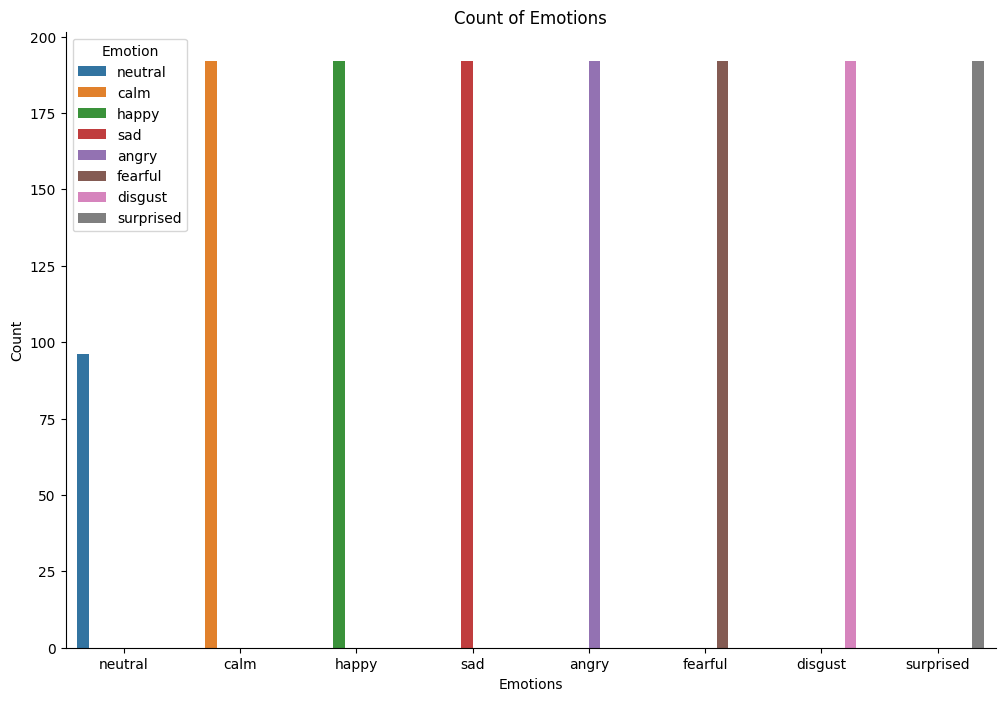

In [5]:
plt.figure(figsize=(12, 8))
plt.title('Count of Emotions')
sns.countplot(x = ravdess_df.Emotion, hue = ravdess_df.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [6]:
def waveplot(data, sr, emo):
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, emo):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

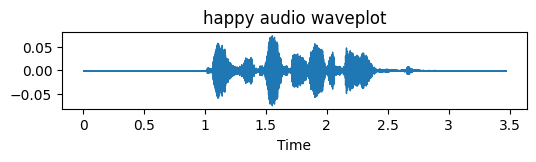

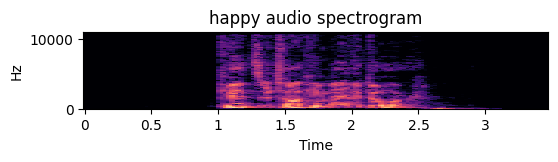

In [7]:
emotion = 'happy'

audio_file_path = np.array(ravdess_df.Path[ravdess_df.Emotion.str.contains(emotion)])[1]
data, sampling_rate = librosa.load(audio_file_path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(audio_file_path)

In [8]:
def noise(data):
  noise_amp = 0.04 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def time_stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data, steps_range = (-5, 5)):
  shift_range = int(np.random.uniform(steps_range[0], steps_range[1]) * 1000)
  return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

def random_time_stretch(data, stretch_factor_range = (0.8, 1.25)):
  random_stretch_factor = np.random.uniform(stretch_factor_range[0], stretch_factor_range[1])

  augmented_data = time_stretch(data, random_stretch_factor)

  if len(augmented_data) > len(data):
    augmented_data = augmented_data[:len(data)]
  else:
    padded_augmented_data = np.zeros_like(data)
    padded_augmented_data[:len(augmented_data)] = augmented_data
    augmented_data = padded_augmented_data

  return augmented_data

def random_pitch_shift(data, sampling_rate, steps_range=(-4, 4)):
  n_steps = np.random.randint(steps_range[0], steps_range[1] + 1)  
  return pitch_shift(data, sampling_rate, n_steps)

In [9]:
def extract_mel(data, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    return mel_spec;

def extract_log_mel_spec(data, sr, n_mels=128, fmax=8000):
    log_mel_spec = librosa.power_to_db(extract_mel(data, sr, n_mels, fmax))
    return log_mel_spec;

def extract_mfcc(data, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc=n_mfcc)
    return mfcc;

def extract_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return delta_mfcc;

def extract_delta_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc;

def extract_zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr

def extract_rms(data):
    rms = librosa.feature.rms(y=data)
    return rms

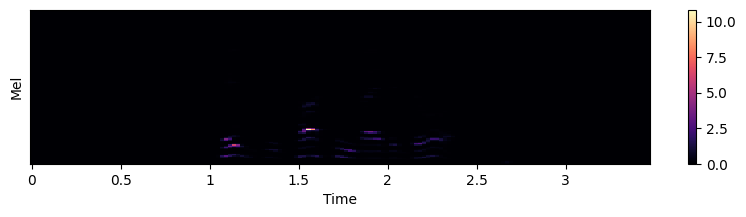

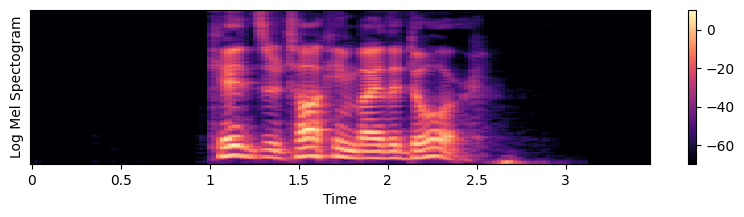

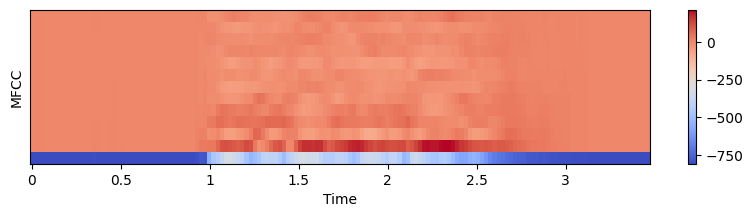

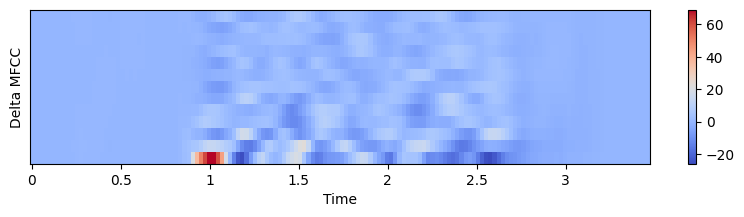

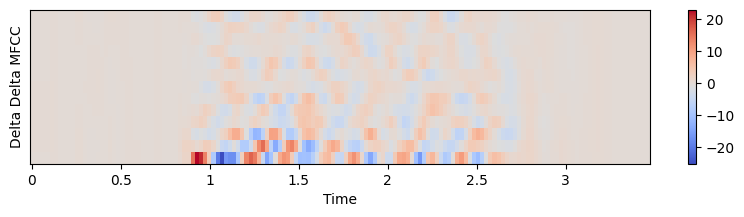

In [10]:
mel = extract_mel(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mel, x_axis='time', sr = sampling_rate)
plt.ylabel('Mel')
plt.colorbar()

log_mel_spec = extract_log_mel_spec(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(log_mel_spec, x_axis='time', sr = sampling_rate)
plt.ylabel('Log Mel Spectogram')
plt.colorbar()

# MFCC
mfcc = extract_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('MFCC')
plt.colorbar()

# ΔMFCC
delta_mfcc = extract_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta MFCC')
plt.colorbar()

# ΔΔMFCC
delta_delta_mfcc = extract_delta_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta Delta MFCC')
plt.colorbar()
plt.show()

# MFCC-based approximate entropy
# MFCC-based spectral entropy
# Three-dimensional Mel-scale frequency cepstral coefficients

In [11]:
# feature_extraction_techniques = ["MFCC", "Delta MFCC", "Delta Delta MFCC"]
# feature_extraction_techniques = ["MFCC Mean 40", "Delta MFCC Mean 40", "Delta Delta MFCC Mean 40"]
feature_extraction_techniques = ["MFCC Mean 40"]

file_name_feat_extract = " & ".join(feature_extraction_techniques)

def extract_features(data, sr, n_mfcc=40):
    # MEAN
    features = np.array([])
    mfcc = extract_mfcc(data, sr, n_mfcc).T
    delta_mfcc = extract_delta_mfcc(data, sr, n_mfcc).T
    delta_delta_mfcc = extract_delta_delta_mfcc(data, sr, n_mfcc).T
    mfcc_mean = np.mean(mfcc, axis=0)
    delta_mfcc_mean = np.mean(delta_mfcc, axis=0)
    delta_delta_mfcc_mean = np.mean(delta_delta_mfcc, axis=0)
    # mfcc_min = np.min(mfcc, axis=0)
    # mfcc_max = np.max(mfcc, axis=0)
    # mfcc_std = np.std(mfcc, axis=0)
    # zcr = np.mean(extract_zcr(data))
    # rms = np.mean(extract_rms(data))
    features = np.hstack((features, mfcc_mean))

    # ENTIRE FEATURE
    # mfcc = extract_mfcc(data, sr).T
    # delta_mfcc = extract_delta_mfcc(data, sr).T
    # delta_delta_mfcc = extract_delta_delta_mfcc(data, sr).T
    # features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=1)
    
    return features

In [12]:
# data_augmentation_techniques = ["Noise", "Random Time Stretch", "Random Pitch Shift"]
# data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "Stretched 0.7", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]
data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]

file_name_data_aug = " & ".join(data_augmentation_techniques)

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=3, offset=0.5)

    noisy_data = noise(data)

    lowspeed_data = time_stretch(data, rate=0.75) #Ignore this
    stretched_data = time_stretch(data, rate=0.7) #Ignore this
    highspeed_data = time_stretch(data, rate=1.25) #Ignore this
    pitch_shift_data = pitch_shift(data, sampling_rate, n_steps=0.7) #Ignore this
    shift_data = shift(data, (-5, 5)) #Ignore this

    random_time_stretch_data = random_time_stretch(data, (0.8, 1.25))
    random_pitch_shift_data = random_pitch_shift(data, sampling_rate, (-4, 4))

    features = extract_features(data, sampling_rate)
    noisy_features = extract_features(noisy_data, sampling_rate)
    
    lowspeed_features = extract_features(lowspeed_data, sampling_rate) #Ignore this
    stretched_features = extract_features(stretched_data, sampling_rate) #Ignore this
    highspeed_features = extract_features(highspeed_data, sampling_rate) #Ignore this
    pitch_shift_features = extract_features(pitch_shift_data, sampling_rate) #Ignore this
    shift_features = extract_features(shift_data, sampling_rate) #Ignore this

    random_time_stretch_features = extract_features(random_time_stretch_data, sampling_rate)
    random_pitch_shift_features = extract_features(random_pitch_shift_data, sampling_rate)

    # result = np.vstack((features, noisy_features, random_time_stretch_features, random_pitch_shift_features))
    result = np.vstack((features, noisy_features, lowspeed_features, highspeed_features, pitch_shift_features, shift_features))

    return result

In [13]:
filename = file_name_dataset + " # " + file_name_feat_extract + " # " + file_name_data_aug

def create_feature_dataframe(dataframe):
    feature_list = []
    emotion_list = []

    for path, emotion in tqdm(zip(dataframe.Path, dataframe.Emotion), total=len(dataframe)):
        features = get_features(path)
        for elements in features:
            feature_list.append(elements)
            emotion_list.append(emotion)

    df = pd.DataFrame({'Emotion': emotion_list})
    df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
    df.to_csv(filename + '.csv', index=False)

    return df

In [14]:
file_exists = os.path.exists(filename + '.csv')

if file_exists:
    df = pd.read_csv(filename + '.csv')
else:
    df = create_feature_dataframe(ravdess_df)

df.head()

,Emotion,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,neutral,-670.195435,65.063850,0.888954,14.715979,9.182164,0.660575,-3.846836,-3.583946,-12.959006,...,-2.351098,-2.504727,-3.151507,-2.190899,-3.801760,-1.813088,-1.261222,-2.144954,-4.152173,-1.779615
1,neutral,-437.411376,24.860678,7.356011,8.004017,5.143942,0.050777,-3.462119,-6.175004,-7.927267,...,-0.913083,-1.325904,-1.392386,-1.818780,-1.903436,-0.807370,-0.963922,-1.762706,-2.651064,-2.611878
2,neutral,-691.445679,62.221443,-0.300504,14.352509,8.497726,0.746647,-4.348557,-4.798969,-14.069670,...,-2.381158,-2.261819,-2.873888,-1.883212,-4.045451,-1.785669,-1.113154,-2.164787,-4.364875,-1.768830
3,neutral,-712.516907,66.194984,1.424330,16.236750,9.380598,1.506902,-4.124938,-3.517112,-13.283334,...,-1.922169,-2.280859,-3.436191,-1.829611,-4.056078,-1.664588,-0.654646,-1.566690,-4.341530,-1.645019
4,neutral,-697.627258,62.472347,-1.029173,15.987646,7.447986,-0.467146,-5.220094,-5.383532,-13.847498,...,-4.750515,-3.052244,-4.137149,-2.542254,-3.379075,-0.843549,-2.677613,-4.869622,-3.312335,-3.609416


In [15]:
X = df.iloc[:, 1:].values
Y = df['Emotion'].values

In [16]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=True)

In [18]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape

((6912, 40), (6912, 8), (864, 40), (864, 8), (864, 40), (864, 8))

In [19]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)
X_validation = x_validation.reshape(x_validation.shape[0] , x_validation.shape[1] , 1)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((6912, 40, 1), (6912, 8), (864, 40, 1), (864, 8), (864, 40, 1), (864, 8))

In [20]:
def create_model(model_type, epochs, filename):
    model = Sequential()
    
    if model_type == 'GRU':
        model.add(GRU(128, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(128, return_sequences=True))
        model.add(GRU(128))
    elif model_type == 'LSTM':
        model.add(LSTM(128, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
    elif model_type == 'BiGRU':
        model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Bidirectional(GRU(128)))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(128)))
    elif model_type == 'CNN':
        model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(256, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
    else:
        raise ValueError("Invalid RNN model. Choose from 'GRU', 'LSTM', 'BiGRU', 'BiLSTM', or 'CNN'.")

    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=3, min_lr=0.00001)
    checkpoint = ModelCheckpoint(filepath=filename + '_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_validation, y_validation), callbacks=[reduce_lr, early_stop, checkpoint])

    #model.save(model_type + ' # Epoch 20.h5')    
    
    return model, history

In [21]:
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

In [22]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [23]:
def simplify_label(label):
    if 'angry' in label:
        return 'angry'
    elif 'disgust' in label:
        return 'disgust'
    elif 'fear' in label:
        return 'fear'
    elif 'happy' in label:
        return 'happy'
    elif 'sad' in label:
        return 'sad'
    elif 'surprise' in label:
        return 'surprise'
    elif 'neutral' in label:
        return 'neutral'
    else:
        return label

In [24]:
def create_model_summary(model_type):
    test_prediction = model_type.predict(X_test)

    prediction_actual_df = pd.DataFrame({
    'Predicted': encoder.inverse_transform(test_prediction).flatten(),
    'Actual': encoder.inverse_transform(y_test).flatten()
    })

    prediction_actual_df.head()

    modified_df = prediction_actual_df.copy()
    modified_df['Actual'] = modified_df['Actual'].apply(simplify_label)
    modified_df['Predicted'] = modified_df['Predicted'].apply(simplify_label)

    res_mat = confusion_matrix(modified_df['Actual'], modified_df['Predicted'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(res_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=modified_df['Predicted'].unique(), 
                yticklabels=modified_df['Actual'].unique())
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(modified_df['Actual'], modified_df['Predicted']))

    accuracy = accuracy_score(modified_df['Actual'], modified_df['Predicted'])
    print(f"Accuracy: {round(accuracy * 100, 2)}%")

In [25]:
model_lstm, history_lstm = create_model("LSTM", 20, 'RAVDESS LSTM')
model_gru, history_gru = create_model("GRU", 20, 'RAVDESS GRU')
model_bilstm, history_bilstm = create_model("BiLSTM", 20, 'RAVDESS BiLSTM')
model_bigru, history_bigru = create_model("BiGRU", 20, 'RAVDESS BiGRU')
model_cnn, history_cnn = create_model("CNN", 20, 'RAVDESS CNN')

Epoch 1/20
108/108 [==============================] - ETA: 0s - loss: 1.8987 - accuracy: 0.2652
Epoch 1: val_accuracy improved from -inf to 0.28472, saving model to RAVDESS LSTM_best.h5
108/108 [==============================] - 15s 91ms/step - loss: 1.8987 - accuracy: 0.2652 - val_loss: 1.8228 - val_accuracy: 0.2847 - lr: 0.0010
Epoch 2/20
107/108 [============================>.] - ETA: 0s - loss: 1.7777 - accuracy: 0.3128
Epoch 2: val_accuracy improved from 0.28472 to 0.30556, saving model to RAVDESS LSTM_best.h5
108/108 [==============================] - 4s 39ms/step - loss: 1.7774 - accuracy: 0.3126 - val_loss: 1.7561 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 3/20
107/108 [============================>.] - ETA: 0s - loss: 1.7292 - accuracy: 0.3283
Epoch 3: val_accuracy improved from 0.30556 to 0.32639, saving model to RAVDESS LSTM_best.h5
108/108 [==============================] - 3s 32ms/step - loss: 1.7296 - accuracy: 0.3278 - val_loss: 1.7276 - val_accuracy: 0.3264 - lr: 0.0010


27/27 [==============================] - 0s 16ms/step - loss: 0.5805 - accuracy: 0.8171
Test Loss: 0.5805453658103943
Test Accuracy: 0.8171296119689941


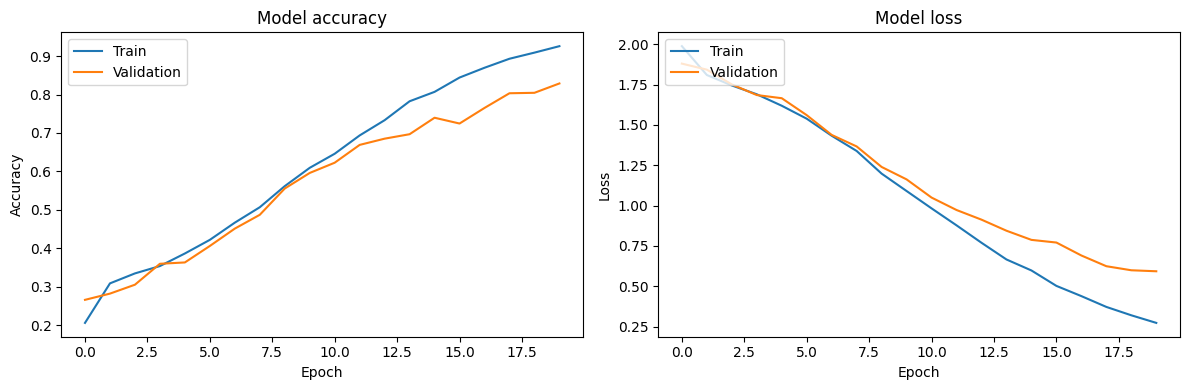

In [26]:
evaluate_model(model_gru)
plot_history(history_gru)

27/27 [==============================] - 11s 355ms/step


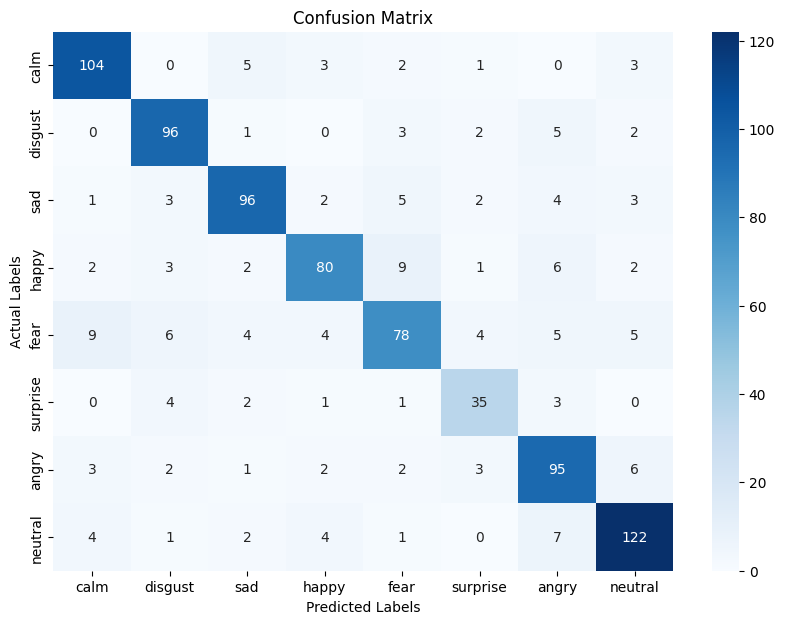

              precision    recall  f1-score   support

       angry       0.85      0.88      0.86       118
        calm       0.83      0.88      0.86       109
     disgust       0.85      0.83      0.84       116
        fear       0.83      0.76      0.80       105
       happy       0.77      0.68      0.72       115
     neutral       0.73      0.76      0.74        46
         sad       0.76      0.83      0.79       114
    surprise       0.85      0.87      0.86       141

    accuracy                           0.82       864
   macro avg       0.81      0.81      0.81       864
weighted avg       0.82      0.82      0.82       864

Accuracy: 81.71%


In [27]:
create_model_summary(model_gru)

27/27 [==============================] - 1s 24ms/step - loss: 0.7392 - accuracy: 0.7581
Test Loss: 0.7391597032546997
Test Accuracy: 0.7581018805503845


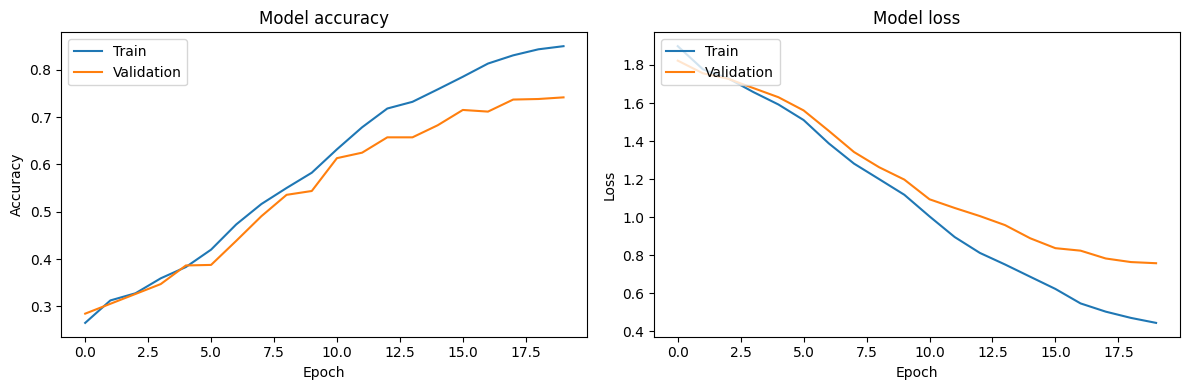

In [28]:
evaluate_model(model_lstm)
plot_history(history_lstm)

27/27 [==============================] - 11s 21ms/step


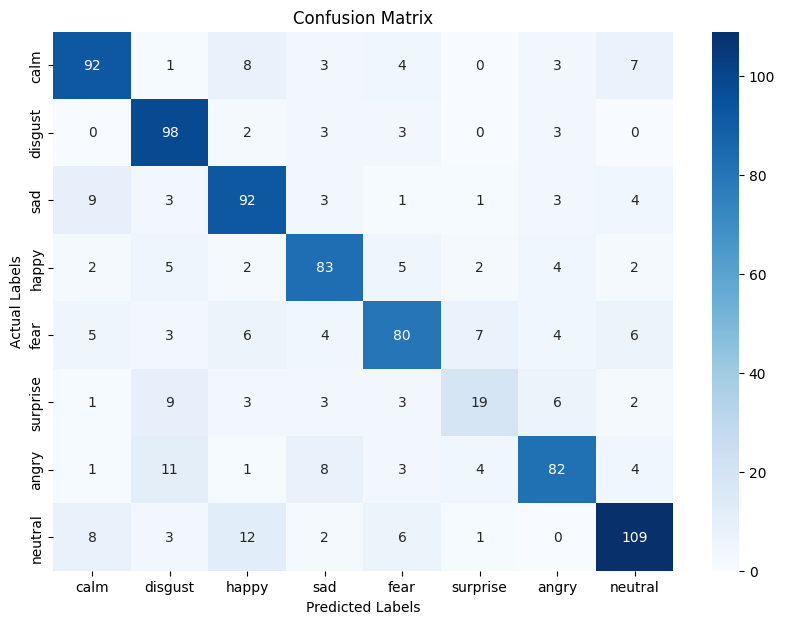

              precision    recall  f1-score   support

       angry       0.78      0.78      0.78       118
        calm       0.74      0.90      0.81       109
     disgust       0.73      0.79      0.76       116
        fear       0.76      0.79      0.78       105
       happy       0.76      0.70      0.73       115
     neutral       0.56      0.41      0.47        46
         sad       0.78      0.72      0.75       114
    surprise       0.81      0.77      0.79       141

    accuracy                           0.76       864
   macro avg       0.74      0.73      0.73       864
weighted avg       0.76      0.76      0.76       864

Accuracy: 75.81%


In [29]:
create_model_summary(model_lstm)

27/27 [==============================] - 11s 439ms/step - loss: 0.5009 - accuracy: 0.8542
Test Loss: 0.5008893609046936
Test Accuracy: 0.8541666865348816


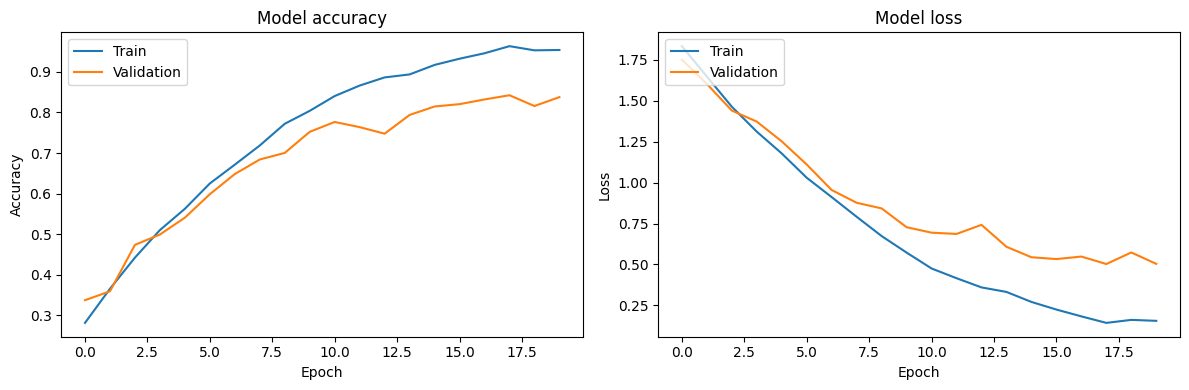

In [30]:
evaluate_model(model_bilstm)
plot_history(history_bilstm)

27/27 [==============================] - 11s 301ms/step


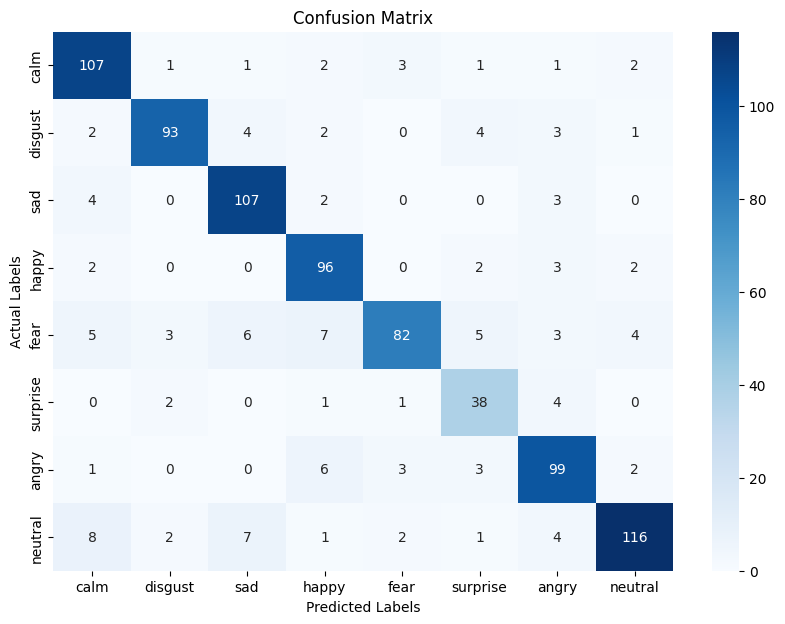

              precision    recall  f1-score   support

       angry       0.83      0.91      0.87       118
        calm       0.92      0.85      0.89       109
     disgust       0.86      0.92      0.89       116
        fear       0.82      0.91      0.86       105
       happy       0.90      0.71      0.80       115
     neutral       0.70      0.83      0.76        46
         sad       0.82      0.87      0.85       114
    surprise       0.91      0.82      0.87       141

    accuracy                           0.85       864
   macro avg       0.85      0.85      0.85       864
weighted avg       0.86      0.85      0.85       864

Accuracy: 85.42%


In [31]:
create_model_summary(model_bilstm)

27/27 [==============================] - 11s 419ms/step - loss: 0.4476 - accuracy: 0.8692
Test Loss: 0.4476453363895416
Test Accuracy: 0.8692129850387573


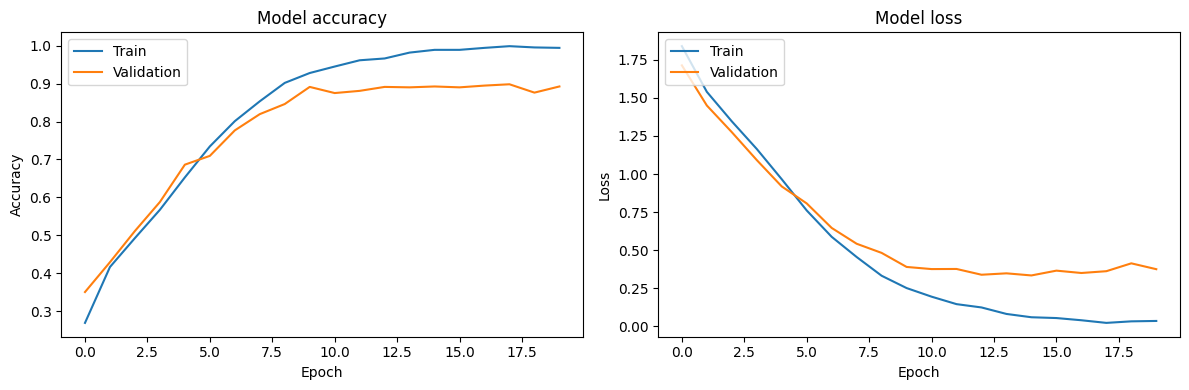

In [32]:
evaluate_model(model_bigru)
plot_history(history_bigru)

27/27 [==============================] - 11s 301ms/step


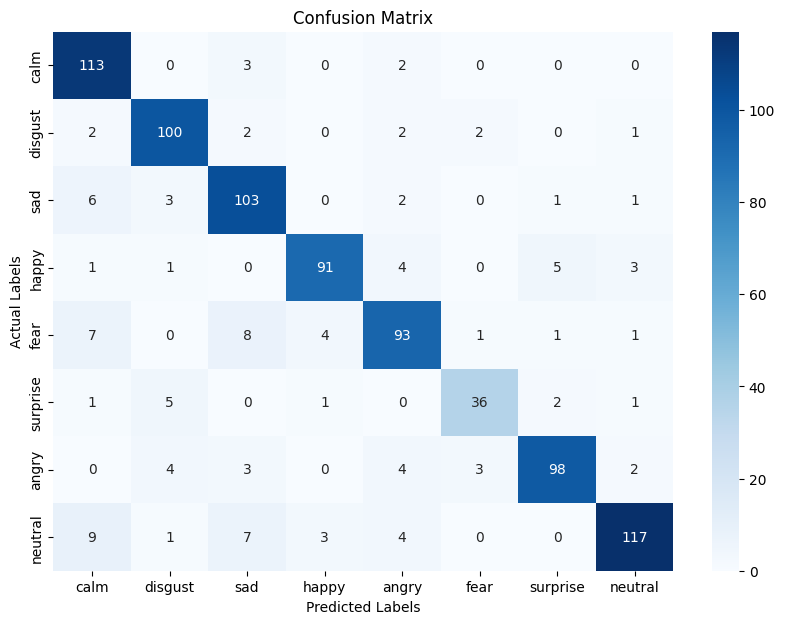

              precision    recall  f1-score   support

       angry       0.81      0.96      0.88       118
        calm       0.88      0.92      0.90       109
     disgust       0.82      0.89      0.85       116
        fear       0.92      0.87      0.89       105
       happy       0.84      0.81      0.82       115
     neutral       0.86      0.78      0.82        46
         sad       0.92      0.86      0.89       114
    surprise       0.93      0.83      0.88       141

    accuracy                           0.87       864
   macro avg       0.87      0.86      0.87       864
weighted avg       0.87      0.87      0.87       864

Accuracy: 86.92%


In [33]:
create_model_summary(model_bigru)

27/27 [==============================] - 0s 7ms/step - loss: 0.2760 - accuracy: 0.9155
Test Loss: 0.276027113199234
Test Accuracy: 0.9155092835426331


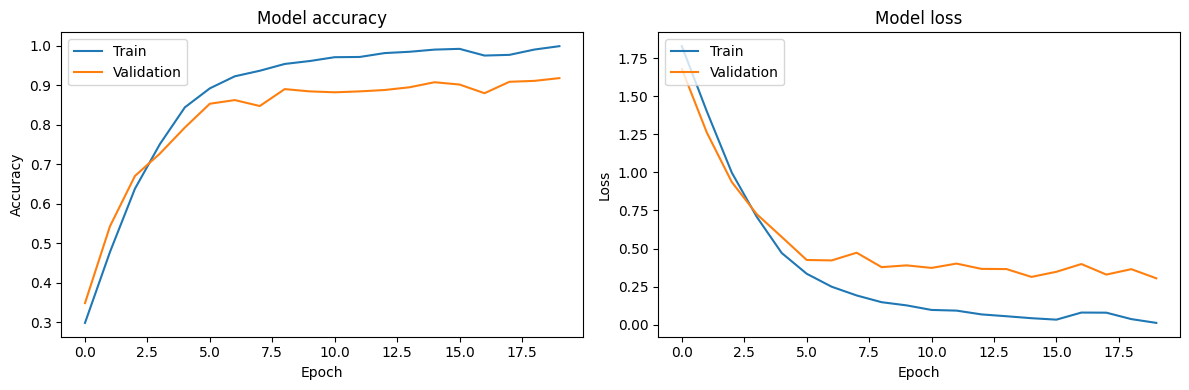

In [34]:
evaluate_model(model_cnn)
plot_history(history_cnn)

27/27 [==============================] - 0s 4ms/step


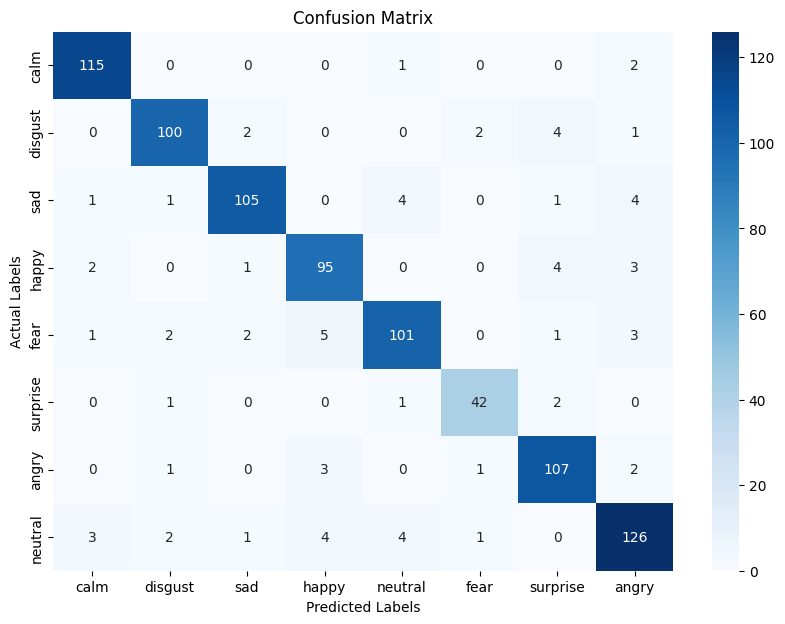

              precision    recall  f1-score   support

       angry       0.94      0.97      0.96       118
        calm       0.93      0.92      0.93       109
     disgust       0.95      0.91      0.93       116
        fear       0.89      0.90      0.90       105
       happy       0.91      0.88      0.89       115
     neutral       0.91      0.91      0.91        46
         sad       0.90      0.94      0.92       114
    surprise       0.89      0.89      0.89       141

    accuracy                           0.92       864
   macro avg       0.92      0.92      0.92       864
weighted avg       0.92      0.92      0.92       864

Accuracy: 91.55%


In [35]:
create_model_summary(model_cnn)